In [1]:
import numpy as np
import pickle
import math
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import csv
import time

In [2]:
piece = 1
midi_pkl_dir = '/home/mshan/ttemp/data/bscore/p1.pkl'
sheet_pkl_dir = '/home/mshan/ttemp/data/bscore_sheet/p1.pkl'
piece_dir = '/home/mshan/ttemp/data/png/p1'

In [3]:
def loadMidiBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    miditimes = d['times']
    num_notes = np.array(d['num_notes'])
    stafflines = d['stafflines']
    return bscore, miditimes, num_notes, stafflines

In [4]:
def loadSheetBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    events = d['events']
    return bscore, events

In [5]:
def normalizedCostMetric(Q, R, numQueryNotes, numRefNotes):
    '''
    Take two vectors, return the normalized cost metric by taking dot product and divided by the maximum norm factor.
    '''
    cost = -Q.T @ R
    query_norm_factor = repmat(numQueryNotes.reshape((-1,1)), 1, R.shape[1])
    ref_norm_factor = repmat(numRefNotes.reshape((1,-1)), Q.shape[1], 1)
    norm_factor = np.maximum(query_norm_factor, ref_norm_factor) + 1e-8 # avoid divide by 0
    norm_cost = cost / norm_factor
    return norm_cost

In [6]:
def computeCostMatrix(query, ref, numRefNotes):
    numQueryNotes = np.sum(query, axis=0)
    C = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)
    return C

In [7]:
def getBoundaryElements(piece, loc):
    '''
    Variable loc could be either 'F' or 'L'.
    Get all elements that are first or last element of a single line, given a piece number.
    '''
    first = []
    last = []
    sheet_pkl_dir = '/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(piece)
    with open(sheet_pkl_dir, 'rb') as pklfile:
        d = pickle.load(pklfile)
        
        for i in range(1, len(d['events'])):
            # check if on the same page as the previous event
            if d['events'][i][2] != d['events'][i-1][2]:
                first.append(i)
                
        for i in range(0, len(d['events'])-1):
            # check if on the same page as the next event
            if d['events'][i][2] != d['events'][i+1][2]:
                last.append(i)
    if loc == 'F':
        return [0] + first
    return last + [len(d['events']) - 1]

In [8]:
getBoundaryElements(1, 'F')[:10], len(getBoundaryElements(1, 'F'))

([0, 16, 30, 41, 79, 126, 175, 222, 273, 323], 75)

In [9]:
def subsequenceDTW(C, steps, weights, piece):

    D = np.zeros(C.shape)
    B1 = np.zeros(C.shape, dtype=np.int16)  # record the r_step that leads to this location
    B2 = np.zeros(C.shape, dtype=np.int16)  # record the c_step that leads to this location
    defaultSteps = steps.tolist()
    
    lastElements = getBoundaryElements(piece, 'L')
    firstElements = getBoundaryElements(piece, 'F')
    
    # Initialize first row
    # Only allow starting from the starting point of a line
    
    for j in range(D.shape[1]):
        if j in firstElements:
            D[0,j] = C[0,j]
        else:
            D[0,j] = np.inf
            
    # Iterate through the matrix
    for r in range(1, C.shape[0]):
        for c in range(0, C.shape[1]):
            # If it is first element, adding extra jump steps leading to this location
            if c in firstElements:
                jumpSteps = [[1, c-k] for k in lastElements]
            else:
                jumpSteps = []
            allSteps = defaultSteps + jumpSteps
        
            weights += [1] * (len(jumpSteps))
                
            minCost = np.inf
            minIdx = -1
            
            for idx in range(len(allSteps)):
                r_step, c_step = allSteps[idx]
                if r >= r_step and c >= c_step and c-c_step < D.shape[1]:
                    cost = D[(r-r_step, c-c_step)] + C[(r, c)] * weights[idx]
                    if cost < minCost:
                        minCost = cost
                        minIdx = idx
                        
            D[(r, c)] = minCost
            B1[(r, c)] = allSteps[minIdx][0]
            B2[(r, c)] = allSteps[minIdx][1]

    optcost = min(D[-1, :])
    path = backtrace(D, B1, B2)
    
    wp = np.array(path)
    
    return optcost, wp, D

In [10]:
def backtrace(D, B1, B2):
    '''
    Take the accumulated cost matrix D, and two helper matrices 
    that record the r_step and c_step that lead to each location in D.
    '''
    path = []
    lastcol = np.argmin(D[-1, :])
    loc = (D.shape[0] - 1, lastcol)
    path.append(loc)
    while loc[0] != 0:
        r, c = loc
        r_step = B1[(r, c)]
        c_step = B2[(r, c)]
        loc = (r - r_step, c - c_step)
        path.append(loc)
    
    return path

In [11]:
def alignBootleg(query, ref, numRefNotes, piece = 1, steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2)), weights = [2,1,1]):
    C = computeCostMatrix(query, ref, numRefNotes)
    opcost, wp, D = subsequenceDTW(C, steps, weights, piece)
    return D, wp

In [12]:
def alignPiece(piece, data='data'):
    midi_pkl_dir = '/home/mshan/ttemp/{}/bscore/p{}.pkl'.format(data, piece)
    sheet_pkl_dir = '/home/mshan/ttemp/{}/bscore_sheet/p{}.pkl'.format(data, piece)
    piece_dir = '/home/mshan/ttemp/{}/png/p{}'.format(data, piece)
    bscore_midi, miditimes, _, stafflines = loadMidiBootlegScore(midi_pkl_dir)
    bscore_sheet,events = loadSheetBootlegScore(sheet_pkl_dir)
    num_notes = np.asarray([len(event[0]) for event in events])
    D, wp = alignBootleg(bscore_midi, bscore_sheet, num_notes, piece=piece)
    plt.figure(figsize = (10,10))
    plt.imshow(D, origin = 'lower', cmap = 'jet')
    plt.plot(wp[:,1], wp[:,0], color='y')
    return D, wp

In [13]:
piece = 11
midi_pkl_dir = '/home/mshan/ttemp/data/bscore/p11.pkl'
sheet_pkl_dir = '/home/mshan/ttemp/data/bscore_sheet/p11.pkl'
piece_dir = '/home/mshan/ttemp/data/png/p11'
bscore_midi, miditimes, _, stafflines = loadMidiBootlegScore(midi_pkl_dir)
bscore_sheet,events = loadSheetBootlegScore(sheet_pkl_dir)
num_notes = np.asarray([len(event[0]) for event in events])

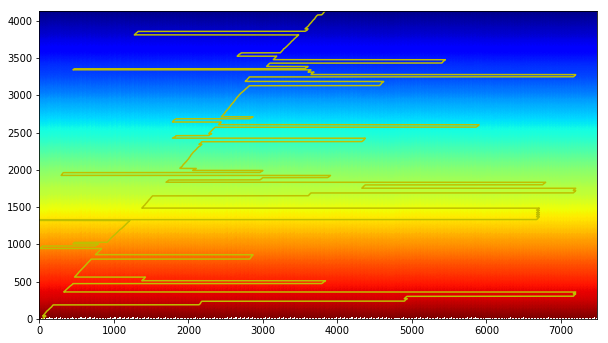

In [57]:
D, wp = alignBootleg(bscore_midi, bscore_sheet, num_notes, piece=piece)
plt.figure(figsize = (10,10))
plt.imshow(D, origin = 'lower', cmap = 'jet')
plt.plot(wp[:,1], wp[:,0], color='y')

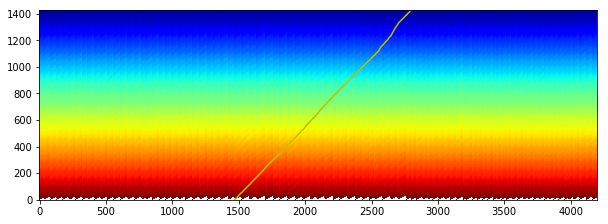

In [59]:
D, wp = alignPiece(15, data='data')

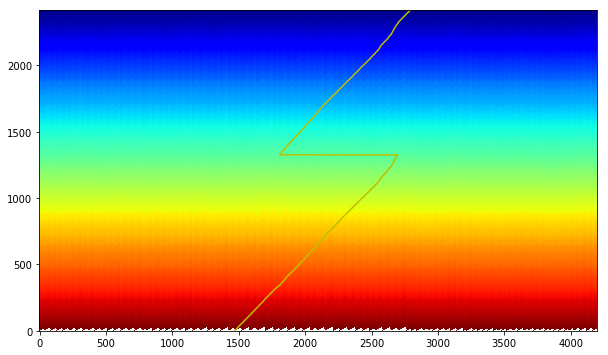

In [60]:
D, wp = alignPiece(15, data='data_repeat1')

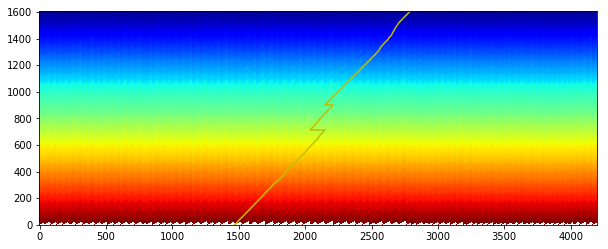

In [61]:
D, wp = alignPiece(15, data='data_repeat2')

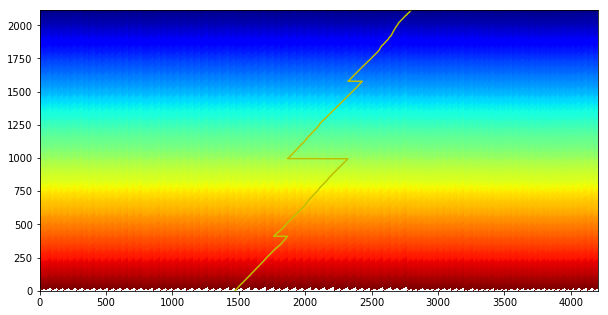

In [62]:
D, wp = alignPiece(15, data='data_repeat3')

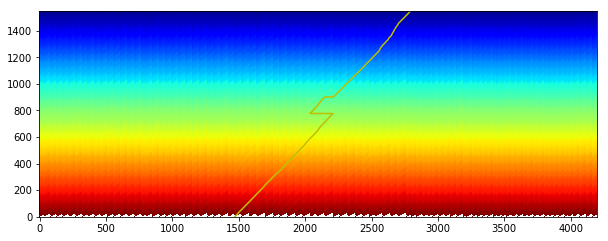

In [63]:
D, wp = alignPiece(15, data='data_dsalfine')

In [21]:
def alignPiece(piece, data='data', save=True):
    filename = '/home/mshan/ttemp/data/hyp/jumpDTW/{}/p{}.pkl'.format(data, piece)
    if path.exists(filename):
        print(filename + "already exists!")
        return
    bscore_midi, miditimes, _, stafflines = loadMidiBootlegScore('/home/mshan/ttemp/{}/bscore/p{}.pkl' .format(data, piece))
    bscore_sheet, events = loadSheetBootlegScore('/home/mshan/ttemp/{}/bscore_sheet/p{}.pkl'.format(data, piece))
    num_notes = np.asarray([len(event[0]) for event in events])
    if num_notes.shape[0] != bscore_sheet.shape[1]:
        bscore_sheet = bscore_sheet[:, 1:]   
    D, wp = alignBootleg(bscore_midi, bscore_sheet, num_notes, piece)
    wp = wp[::-1]
    times = [miditime[0] for miditime in miditimes]
    midi_frame = [time_point[0] for time_point in wp]
    actual_time = [times[k] for k in midi_frame]
     
    if save:
        d = {}
        d['events'] = events
        d['actual_time'] = actual_time
        d['wp'] = wp
        with open('/home/mshan/ttemp/data/hyp/jumpDTW/{}/p{}.pkl'.format(data, piece), 'wb') as f:
            pickle.dump(d, f)
        print('/home/mshan/ttemp/data/hyp/jumpDTW/{}/p{}.pkl'.format(data, piece))
    else:
        return D, wp

### Experiments

In [24]:
import multiprocessing 
from os import path
for data in ['data_repeat2', 'data_repeat3', 'data_dsalfine']:
    for piece in test_list:
        p = multiprocessing.Process(target=alignPiece, args=(piece, data,))
        p.start()

/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p4.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p3.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p2.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p6.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p7.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p8.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p9.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p10.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p12.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p13.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p14.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p16.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p17.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p19.pklalready exists!
/home/mshan/t

/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p147.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p153.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p152.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p154.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p157.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p158.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p162.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p163.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p164.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p166.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p167.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p168.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p172.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p169.pklalready 

/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p104.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p106.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p107.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p108.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p110.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p109.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p112.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p113.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p114.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p116.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p117.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p118.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p119.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p120.pklalready 

/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p62.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p63.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p64.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p60.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p66.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p67.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p68.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p69.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p70.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p73.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p76.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p74.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p78.pklalready exists!
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p77.pklalready 

/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat2/p133.pkl
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p133.pkl
/home/mshan/ttemp/data/hyp/jumpDTW/data_dsalfine/p54.pkl
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p8.pkl
/home/mshan/ttemp/data/hyp/jumpDTW/data_repeat3/p54.pkl
